# NBD - Homework 1 -  Networking

## Part 1

### Write a script to generate a p-ER random graph

### Write a script to generate an r-regular random graph.

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy.linalg as alg
import numpy as np
from collections import deque
from numpy import inf
import random
import queue as qu

In [3]:
n = 6
m = 3
p = 0.3
r = 5

# create a G_n,m random graph
Gnm = nx.gnm_random_graph(n = n, m = m)
# the adjacency matrix
A_Gnm = nx.to_numpy_matrix(Gnm)
# create a G_n,p random graph
Gnp = nx.gnp_random_graph(n=n, p=p)
# the adjacency matrix
A_Gnp = nx.to_numpy_matrix(Gnp)
# create a r-regular random graph
rrG = nx.random_regular_graph(d=r, n=n)
# the adjacency matrix
A_rrG = nx.to_numpy_matrix(rrG)

Without using libraries...

In [38]:
class Error(Exception):
...     def __init__(self, value):
...         self.value = value
...     def __str__(self):
...         return repr(self.value)


def r_regular(n, k) :
    
    if (n * k) % 2 != 0:
        raise Error("n * d must be even")

    if not 0 <= k < n:
        raise Error("the 0 <= d < n inequality must be satisfied")

    graph=nx.Graph()
    c=nx.path_graph(n)
    graph.add_nodes_from(c)
    # initialize link, a dictionary containing, for each node, the number of available ports
    links = {}
    for i in range(0,n) :
        links[i] = k
    
    """pos = nx.spring_layout(graph)
    nx.draw(graph, pos)
    plt.show() """

    # while a couple of nodes with free ports still exists...
    while len(links)>1:
        # sample two items from the set of those nodes
        randomSample = random.sample(links.items(), 2)
        (nodeA, kA) = randomSample[0]
        (nodeB, kB) = randomSample[1]
       
        while (graph.has_edge(nodeA,nodeB) and len(links) != 2):
            # randomly select 2 nodes and check if the 2 nodes are already connected
            randomSample = random.sample(links.items(), 2)
            (nodeA, kA) = randomSample[0]
            (nodeB, kB) = randomSample[1]
        
        graph.add_edge(nodeA,nodeB)
        
        """print(nodeA, nodeB)
        nx.draw(graph, pos, with_labels=True)
        plt.show() """
        
        # update the number of free links for each node:
        # if the number of available ports was 1, delete the node, 
        # else: decrease the number by 1
        if kA == 1:
            del links[nodeA]
        else :
            links[nodeA] = kA - 1
        if kB == 1:
            del links[nodeB]
        else :
            links[nodeB] = kB - 1
    if len(links) == 1: print('*')
    return(graph)
    
G = r_regular(10,4)

In [5]:
def p_ER_graph(n, p) :
    """
    Input:
    - n: number of nodes in the graph
    - p: probability that two nodes are connected 
    
    Ouput: 
    - graph: a p-Erdos Renyi graph
    """
    
    if not 0 <= p <= 1:
        raise Error("p must lie in [0,1]")

    graph=nx.Graph()
    
    # each couple of nodes are connected with probability p
    for i in range(0,n) :
        for j in range((i+1),n):
            out = random.uniform(0,1)
            if out < p:
                graph.add_edge(i,j)
    
    return(graph)

G = p_ER_graph(10, 0.1)

Write a script to check the connectivity of a given graph.
- algebraic method 1 (irreducibility);
- algebraic method 2 (eigenvalue of the Laplacian matrix);
- breadth-first search algorithm.


In [18]:
# Irreducibility

def Irreducibility(G):
    """
    This function checks the connectivity of a graph testing its irreducibility.
    
    Input:
    - G: a graph
    
    Output:
    - 1 if the graph is connected, 0 otherwise
    """
    A = nx.to_numpy_matrix(G)
    n = A.shape[0]
    S = np.zeros((n,n))
    for n in range(n):
        S = S + alg.matrix_power(M=A, n=n)
    
    if S.all() > 0: 
        #print('The graph is irreducible,\n-> The graph is connected')
        return(1)
    else:
        return(0)
    
Irreducibility(rrG)

1

In [19]:
# Eigenvalue of the Laplacian Matrix

def Laplacian(G):
    """
    This function checks the connectivity of a graph through the Laplacian matrix.
    
    Input:
    - G: a graph
    
    Output:
    - 1 if the graph is connected, 0 otherwise
    """
    # graph adjacency matrix
    A = nx.to_numpy_matrix(G)
    # diagonal matrix matrix containing degrees
    D = np.diag([degree[1] for degree in nx.degree(G=G)])
    # Laplacian matrix
    L = D-A
    eig = np.sort(alg.eigvalsh(L))
    #print(eig)
    if eig[1] > 0: return(1)
    else: return(0)
    
Laplacian(rrG)

1

In [21]:
# Breath First Search

def BFS(G, i):
    '''
    This function performs the Breath First Search algorithm in order to find the hop-distances of all the 
    other nodes in the graph with respect to node i.
    
    Input:
    - G: a graph
    - i: a root
    
    Output: 
    - distances: a dictionary in which each key is a node of G, 
        and each value is the hop-distance from the root i
    '''
    # initialization
    for node in list(G.nodes):
        G.node[node]["Distance"] = inf
        G.node[node]["Parent"] = "NIL"
    Q = qu.Queue()
    root = i
    G.node[root]["Distance"] = 0
    Q.put(root)
    while not Q.empty():
        current = Q.get()
        for neigh in nx.all_neighbors(G,current):
            if G.node[neigh]["Distance"] == inf:
                G.node[neigh]["Distance"] = G.node[current]["Distance"]+1
                G.node[neigh]["Parent"] = current
                Q.put(neigh)

    distances = nx.get_node_attributes(G, "Distance").values()
    return(distances)

def BFS_connectivity(G):
    '''
    This function check if a graph is connected using the Breath First Search algorithm.
    BFS is performed starting from each node in the graph.
    Then, every time the function checks whether any of the hop-distances is infinite.
    If the control passes for each node in the graph, we can assert that the graph is connected.
    
    Input:
    - G a graph
    
    Output: 
    - 1 if the graph is connected, 0 otherwise
    '''
    for start in G.nodes():
        distances = list(BFS(G, start))
        if any(t == inf for t in distances):   
            return(0)
    return(1)
    
G = nx.random_regular_graph(d=3, n=20)
BFS_connectivity(G=G)

1

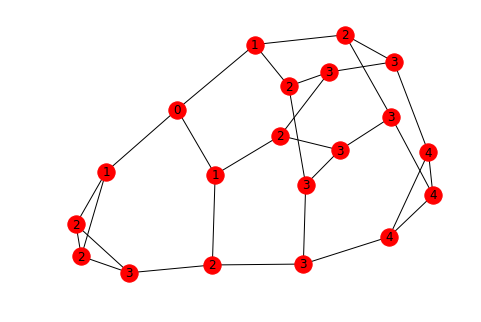

In [22]:
# Plot the graph

pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G,'Distance')
nx.draw_networkx_labels(G,pos, labels = node_labels)
plt.show() 

### Compare the complexity as a function of n of the methods above

Checking connectivity with BFS is O(n(n + n(n-1)/2)) = O(n^3)

Irreducibility's complexity is O(n n^3) = O(n^4)

Complexity in Laplacian is O(n logn (n^3)) = O(n^4 logn)

### Consider the probability that a graph G is connected: produce two plots:

- pc(G) vs. p for Erdos-Renyi graphs G(n; p) with n = 100

- pc(G) vs. n for r -regular random graphs with r = 2; 4; 8; 16 and n ranging up to 100

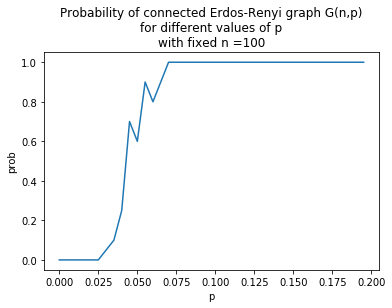

In [261]:
def p_er_re(n = 100, p_from = 0, p_to = 0.2, p_by = 0.005):
    # simulation size for propability estimation
    B = 10
    # create a vector of probabilities
    p = np.arange(p_from,p_to,p_by)
    # initiate outcome list
    pc = []
    for i in range(len(p)):
        phat = []
        for b in range(B): 
            # create a G_n,p random graph
            Gnp = nx.gnp_random_graph(n=n, p=p[i])
            # check whether the graph is connected and append the
            # result of the test in the out list
            phat.append(BFS_connectivity(Gnp))
        phat = np.array(phat)
        pc.append(np.mean(phat))
    x = p
    y = pc
    plt.plot(x, y)
    
    plt.title("Probability of connected Erdos-Renyi graph G(n,p)\nfor different values of p\nwith fixed n ="+ str(n))
    plt.ylabel("prob")
    plt.xlabel("p")
    plt.legend(loc = "upper right")
    plt.show()
    return

p_er_re()

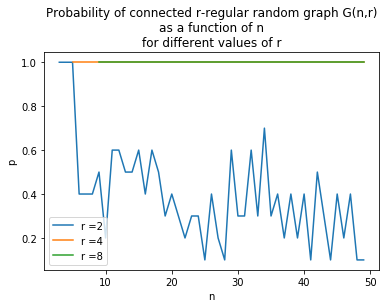

In [23]:
def p_rrrg(r_list =  [2,4,8], nmax = 50):
    for r in r_list:
        # simulation size for propability estimation
        B = 10
        # initiate outcome list
        pc = []
        for i in range(r+1,nmax):
            phat = []
            for b in range(B): 
                # create a r-regular random graph
                rrG = nx.random_regular_graph(d=r, n=i)
                # check whether the graph is connected and append the
                # result of the test in the out list
                phat.append(BFS_connectivity(rrG))
            phat = np.array(phat)
            pc.append(np.mean(phat))
        x = np.array(list(range(r+1,nmax)))
        y = pc
        plt.plot(x, y, label = 'r =' + str(r))
    
    plt.title("Probability of connected r-regular random graph G(n,r)\nas a function of n\nfor different values of r")
    plt.ylabel("p")
    plt.xlabel("n")
    plt.legend(loc = "lower left")
    plt.show()
    return

p_rrrg()

## Part 2

In [203]:
def jellyfish(n, k):
    """
    This function generates a random graph
    
    Input:
    - n: number of nodes
    - k: the number of ports available in each switch
    
    Output:
    -graph: a graph
    """
    
    # initialize a graph connecting all the nodes with n-1 edges    
    graph=nx.Graph()
    c=nx.path_graph(n)
    graph.add_nodes_from(c)
    # links dictionary contains the number of free ports for each node in the graph
    links = {}
    g = {}
    # for each node...
    for i in range(0,n) :
        # ... there are k links
        links[i] = k
        # ... and links are stored in a set
        g[i] = set([])
    
    # repeat the same until the randomly selected nodes are connected and they are not distinct
    while len(links) > 1 :

        randomSample = random.sample(links.items(), 2)
        (nodeA, kA) = randomSample[0]
        (nodeB, kB) = randomSample[1]
    
        while (graph.has_edge(nodeA,nodeB)) and len(links)!=2:
           # randomly select 2 nodes and check if the 2 nodes are already connected
            randomSample = random.sample(links.items(), 2)
            (nodeA, kA) = randomSample[0]
            (nodeB, kB) = randomSample[1]
            
        # assume all links are bidirectional... update g
        g[nodeA].add(nodeB)
        g[nodeB].add(nodeA)
        graph.add_edge(nodeA, nodeB) 

        # update the number of free links for each node
        if kA == 1:
            del links[nodeA]
        else :
            links[nodeA] = kA - 1
        if kB == 1:
            del links[nodeB]
        else :
            links[nodeB] = kB - 1

    # check if there is a single switch with more than 2 unmatched ports
    # if there is only one switch left: remove a random link etc..
    if (len(links) == 1) :

        (node, linksLeft) = list(links.items())[0]
        while (linksLeft > 1) :
            # choose a "a" node in the dictionary containing nodes with no free ports
            # it must be distinct from "node" and doesn't have to be a neighbor of "node"
            a = random.randint(0, len(g) - 1)
            while (a == node or a in g[node]) :                                                            # or len(g[a] - set([node])) == 0 
                a = random.randint(0, len(g) - 1)
            # choose node "b"  neighbor of "a"
            b = random.choice(list(g[a]))
            while (b in g[node]) :
                b = random.choice(list(g[a]))
            # remove link is (a, b), add new links (node, a), (node, b)
            g[a].remove(b)
            g[b].remove(a)
            graph.remove_edge(a, b)
            g[node].add(a)
            g[a].add(node)
            g[node].add(b)
            g[b].add(node)
            graph.add_edge(node, a)
            graph.add_edge(node, b)
            linksLeft = linksLeft - 2
            
    return graph

### Write a script that: 

(i) generates a random graph describing
the topology of the ToR switch network; 

(ii) checks its
connectivity; 

(iii) finds shortest path routes; 

(iv) estimates the mean of the lengths 
    of the shortest paths connecting all node pairs

In [26]:
def shortest_paths(G, source):
    """
    This function computes the shortest path from a source node using Dijkstra's algorithm
    
    Input:
    - G a graph
    - source: a node in the graph

    Output:
    -a tuple (distances, paths) ,where
    
    -- distances: dictionary of nodes already visited, key node and value the number of hops to 
        get there from the source
    -- paths: dictionary that contains, for node in the graph, the 
        shortest path connecting him with the source
    """
    # initiate all the distances to inf except for the source node that has distance 0 from itself
    distances = {}
    parents = {}
    for node in list(G.nodes):
            distances[node] = inf
            parents[node] = 'nil'
    distances[source] = 0
    
    # create FIFO queue of nodes to visit and enqueue the source node toghether with its distance
    to_visit = deque([])
    to_visit.append((source, 0))

    #while there is something to visit in the queue
    while len(to_visit) > 0:
        #remove the first element from the queue and visit it 
        node = to_visit.popleft()
        # for each neighbour of the current node...
        for neighbor in G.neighbors(node[0]):
            # 
            if (distances[neighbor] > node[1]+ 1):
                to_visit.append((neighbor, node[1] + 1 ))
                distances[neighbor] = node[1]+ 1
                parents[neighbor] = node[0]
                    
    #we are done visiting everything 
    
    paths = {}
    for node in list(G.nodes):
        S = []
        u = node
        #print(u)
        while parents[u] in parents:
            S.append(u)
            u = parents[u]
        S.append(source)
        paths[node] = S
    
    return ((distances, paths))

shortest_paths(G, 0)

({0: 0,
  1: 3,
  2: 3,
  3: 3,
  4: 2,
  5: 3,
  6: 2,
  7: 3,
  8: 1,
  9: 3,
  10: 4,
  11: 4,
  12: 3,
  13: 1,
  14: 1,
  15: 2,
  16: 2,
  17: 2,
  18: 2,
  19: 3},
 {0: [0],
  1: [1, 17, 8, 0],
  2: [2, 17, 8, 0],
  3: [3, 18, 8, 0],
  4: [4, 13, 0],
  5: [5, 15, 14, 0],
  6: [6, 14, 0],
  7: [7, 4, 13, 0],
  8: [8, 0],
  9: [9, 18, 8, 0],
  10: [10, 2, 17, 8, 0],
  11: [11, 12, 6, 14, 0],
  12: [12, 6, 14, 0],
  13: [13, 0],
  14: [14, 0],
  15: [15, 14, 0],
  16: [16, 13, 0],
  17: [17, 8, 0],
  18: [18, 8, 0],
  19: [19, 15, 14, 0]})

In [27]:
def all_shortest_paths(G):
    """
    This function returns a dictionary,
    containing, for each node, a nested dictionary with all the possible paths to the other
    nodes.
    """
    return({i: shortest_paths(G, i)[1] for i in G.nodes}   )

all_shortest_paths(rrG)

{0: {0: [0], 1: [1, 0], 2: [2, 0], 3: [3, 0], 4: [4, 0], 5: [5, 0]},
 1: {0: [0, 1], 1: [1], 2: [2, 1], 3: [3, 1], 4: [4, 1], 5: [5, 1]},
 2: {0: [0, 2], 1: [1, 2], 2: [2], 3: [3, 2], 4: [4, 2], 5: [5, 2]},
 3: {0: [0, 3], 1: [1, 3], 2: [2, 3], 3: [3], 4: [4, 3], 5: [5, 3]},
 4: {0: [0, 4], 1: [1, 4], 2: [2, 4], 3: [3, 4], 4: [4], 5: [5, 4]},
 5: {0: [0, 5], 1: [1, 5], 2: [2, 5], 3: [3, 5], 4: [4, 5], 5: [5]}}

In [21]:
def hbar(G):
    """
    This function computes the mean of the lengths 
    of the shortest paths connecting all node pairs.
    
    The function performs Dijkstra's algorithm starting from 
    each node; every time it appends the length of the
    shortest paths from the source in a list.
    
    The last step is take the average of the elements 
    in the list.
    
    Input:
    - G: a graph
    
    Output:
    -hbar: mean of the lengths of the shortest paths 
    connecting all node pairs
    """
    distances = []
    for i in list(G.nodes):
        distances.append(list(shortest_paths(G, i)[0]))
    hbar = np.mean(np.array(distances))                                                                    # div (n-1)
    return (hbar)
    

The graph is connected
[9, 1]


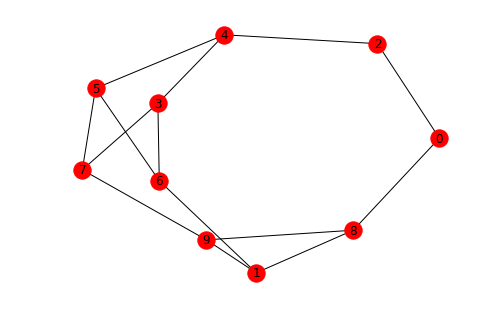

average h = 4.5


In [228]:
# generates a random graph describing the topology of the ToR switch network
G = jellyfish(10, 3)

# checks its connectivity
if Laplacian(G) == 1: print("The graph is connected")
else: print("The graph is not connected")
    
# shortest path routes
source = 1
target = 9
print(all_shortest_paths(G)[source][target])

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
plt.show() 

# estimate the mean of the lengths of the shortest paths connecting all node pairs
print("average h =", hbar(G))

### Plot the application-oblivious throughput bound TH, versus n for the two graph models

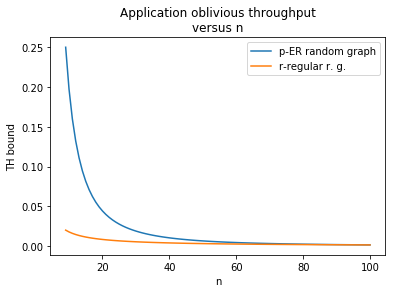

In [23]:
TH = []
for n in range(9,101): 
    p = 8/(n-1)
    # create a G_n,p random graph
    Gnp = nx.gnp_random_graph(n=n, p=p)
    TH.append(p/hbar(Gnp))

x = np.array(list(range(9,101)))
y = np.array(TH)
plt.plot(x, y,label = 'p-ER random graph')

TH = []
for n in range(9,101): 
    r = 8
    # create a G_n,r regular random graph
    rrG = nx.random_regular_graph(d=r, n=n)
    TH.append(r/(hbar(Gnp)*(n-1)))

x = np.array(list(range(9,101)))
y = np.array(TH)
plt.plot(x, y,label = 'r-regular r. g.')

plt.title("Application oblivious throughput\nversus n")
plt.ylabel("TH bound")
plt.xlabel("n")
plt.legend(loc = "upper right")
plt.show()

### Assume a link can break down (fail) with probability q.

Plot TH as a function of q for 0 < q < 0,25, for the two network models in point above with n = 100.

In [24]:
def failure(G, q):
    """
    This function simulates failures among 
    the connections in a network.
    
    Input:
    -G: a graph
    -q: probability that a connection breaks down

    Output:
    -G: the graph given in input whithout the failed connections
    """

    edges = list(G.edges())
    for i in range(len(G.edges())):
        x = random.uniform(0,1)
        if x < q: 
            G.remove_edge(edges[i][0], edges[i][1])
            
    return G

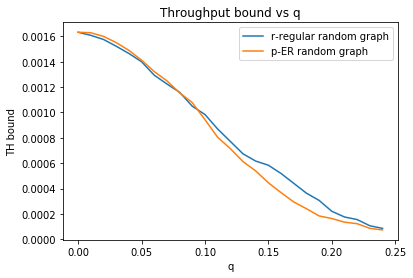

In [25]:
def throughput(G):
    """
    This function evaluates the throughput bound given a specific graph.
    Here there are no assuptions on the nature of the graph.
    
    Input:
    - G: a graph
    
    Output:
    - t: the estimated throughput
    """
    
    m = len(G.edges())
    h = hbar(G)
    v = n*(n-1)/2
    t = m/(h*v)
    return (t)

def thr_vs_q_rrG (n=100):
    """
    This function evaluates the throughput bound of an r-regular random graph as a function of q,
    with n fixed,where q is corresponding to the probability that a link can break down(fail).
    Here r (degree for each node) is taken to be 8
    
    Input:
    - n: Number of nodes 
    
    Output:
    - TH: the estimated throughput evaluated each time for a specific prob. q
    """
    r = 8
    G = nx.random_regular_graph(d=r, n=n)
    Q = np.arange(0,0.25,0.01)
    TH = []
    for q in Q:
        G = failure(G, q)
        TH.append(throughput(G))
    return TH
    
    
def thr_vs_q_pER (n=100):
    """
    This function evaluates the throughput bound of a p-ER random graph as a function of q,
    with n fixed,where q is corresponding to the probability that a link can break down(fail).
    Here  r (degree for each node) is taken to be 8
    
    Input:
    - n: Number of nodes 
    
    Output:
    - TH: the estimated throughput evaluated each time for a specific prob. q
    """
    p = 8/(n-1)
    G = nx.gnp_random_graph(n=n, p=p)
    Q = np.arange(0,0.25,0.01)
    TH = []
    for q in Q:
        G = failure(G, q)
        TH.append(throughput(G))
    return TH
    
    
x = np.arange(0,0.25,0.01)
y = thr_vs_q_rrG()
plt.plot(x, y, label = "r-regular random graph")

x = np.arange(0,0.25,0.01)
y = thr_vs_q_pER()
plt.plot(x, y, label = "p-ER random graph")

plt.title("Throughput bound vs q")
plt.ylabel("TH bound")
plt.xlabel("q")
plt.legend(loc = "upper right")
plt.show()